In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn import svm
import matplotlib.pyplot as plt


def preprocess():
    """ 
     Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set
    """

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    n_feature = mat.get("train1").shape[1]
    n_sample = 0
    for i in range(10):
        n_sample = n_sample + mat.get("train" + str(i)).shape[0]
    n_validation = 1000
    n_train = n_sample - 10 * n_validation

    # Construct validation data
    validation_data = np.zeros((10 * n_validation, n_feature))
    for i in range(10):
        validation_data[i * n_validation:(i + 1) * n_validation, :] = mat.get("train" + str(i))[0:n_validation, :]

    # Construct validation label
    validation_label = np.ones((10 * n_validation, 1))
    for i in range(10):
        validation_label[i * n_validation:(i + 1) * n_validation, :] = i * np.ones((n_validation, 1))

    # Construct training data and label
    train_data = np.zeros((n_train, n_feature))
    train_label = np.zeros((n_train, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("train" + str(i)).shape[0]
        train_data[temp:temp + size_i - n_validation, :] = mat.get("train" + str(i))[n_validation:size_i, :]
        train_label[temp:temp + size_i - n_validation, :] = i * np.ones((size_i - n_validation, 1))
        temp = temp + size_i - n_validation

    # Construct test data and label
    n_test = 0
    for i in range(10):
        n_test = n_test + mat.get("test" + str(i)).shape[0]
    test_data = np.zeros((n_test, n_feature))
    test_label = np.zeros((n_test, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("test" + str(i)).shape[0]
        test_data[temp:temp + size_i, :] = mat.get("test" + str(i))
        test_label[temp:temp + size_i, :] = i * np.ones((size_i, 1))
        temp = temp + size_i

    # Delete features which don't provide any useful information for classifiers
    sigma = np.std(train_data, axis=0)
    index = np.array([])
    for i in range(n_feature):
        if (sigma[i] > 0.001):
            index = np.append(index, [i])
    train_data = train_data[:, index.astype(int)]
    validation_data = validation_data[:, index.astype(int)]
    test_data = test_data[:, index.astype(int)]

    # Scale data to 0 and 1
    train_data /= 255.0
    validation_data /= 255.0
    test_data /= 255.0

    return train_data, train_label, validation_data, validation_label, test_data, test_label


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def blrObjFunction(initialWeights, *args):
    """
    blrObjFunction computes 2-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector (w_k) of size (D + 1) x 1 
        train_data: the data matrix of size N x D
        labeli: the label vector (y_k) of size N x 1 where each entry can be either 0 or 1 representing the label of corresponding feature vector

    Output: 
        error: the scalar value of error function of 2-class logistic regression
        error_grad: the vector of size (D+1) x 1 representing the gradient of
                    error function
    """
    train_data, labeli = args

    n_data = train_data.shape[0]
    n_features = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_features + 1, 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    w = initialWeights.reshape((n_feature+1,1))
    
    x = np.hstack((np.ones((n_data,1)),train_data))
    xw = np.dot(x,w)
    y = sigmoid(xw)

    log_error = -(labeli * np.log(y) + (1.0 - labeli) * np.log(1.0 - y))
    error = np.sum(log_error)

    error_grad_mat = (y - labeli) * x
    error_grad = np.sum(error_grad_mat, axis=0)
    
    return error, error_grad


def blrPredict(W, data):
    """
     blrObjFunction predicts the label of data given the data and parameter W 
     of Logistic Regression
     
     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight 
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D
         
     Output: 
         label: vector of size N x 1 representing the predicted label of 
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    x = np.hstack((np.ones((data.shape[0], 1)),data))
    xw = np.dot(x, W)
    sig_fun = sigmoid(xw)   
    label_max = np.argmax(sig_fun, axis=1)   
    label = label_max.reshape((data.shape[0],1))
    return label

def mlrObjFunction(params, *args):
    """
    mlrObjFunction computes multi-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights_b: the weight vector of size (D + 1) x 10
        train_data: the data matrix of size N x D
        labeli: the label vector of size N x 1 where each entry can be either 0 or 1
                representing the label of corresponding feature vector

    Output:
        error: the scalar value of error function of multi-class logistic regression
        error_grad: the vector of size (D+1) x 10 representing the gradient of
                    error function
    """
    train_data, labeli = args
    n_data = train_data.shape[0]
    n_feature = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_feature + 1, n_class))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    x = np.hstack((np.ones((n_data,1)),train_data))
        
    n=np.exp(np.dot(train_data,params.reshape(716,10)))
        
    w_sum=np.sum(n,axis=1)
    d=w_sum.reshape(w_sum.shape[0],1)
    
    t=n/d  
    
    error = -(np.sum(labeli*np.log(t)))

    error_grad = np.dot(train_data.transpose(),(t-labeli))
    
    error_grad=error_grad.ravel()
    
    return error, error_grad


def mlrPredict(W, data):
    """
     mlrObjFunction predicts the label of data given the data and parameter W
     of Logistic Regression

     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D

     Output:
         label: vector of size N x 1 representing the predicted label of
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    x = np.hstack((np.ones((data.shape[0], 1)),data))
    n=np.exp(np.dot(x,W))
        
    w_sum=np.sum(n,axis=1)
    d=w_sum.reshape(w_sum.shape[0],1)
    
    t=n/d   
    label_max = np.argmax(t, axis=1)   
    label = label_max.reshape((data.shape[0],1))
    return label


"""
Script for Logistic Regression
"""
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# number of classes
n_class = 10

# number of training samples
n_train = train_data.shape[0]

# number of features
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()

# Logistic Regression with Gradient Descent
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1))
opts = {'maxiter': 100}
for i in range(n_class):
    labeli = Y[:, i].reshape(n_train, 1)
    args = (train_data, labeli)
    nn_params = minimize(blrObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    W[:, i] = nn_params.x.reshape((n_feature + 1,))

# Find the accuracy on Training Dataset
predicted_label_tr = blrPredict(W, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label = blrPredict(W, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_te = blrPredict(W, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label == test_label).astype(float))) + '%')

"""
Script for Support Vector Machine
"""

print('\n\n--------------SVM-------------------\n\n')
##################
# YOUR CODE HERE #
##################
# Using linear kernel
print('SVM Using linear kernel')
out = SVC(kernel='linear')
out.fit(train_data, train_label.flatten())
print('\n Training Accuracy:' + str(100*out.score(train_data, train_label)) + '%')
print('\n Validation Accuracy:' + str(100*out.score(validation_data, validation_label)) + '%')
print('\n Testing Accuracy:' + str(100*out.score(test_data, test_label)) + '%')


# Using radial basis function with value of gamma setting to 1
print('\n\n SVM Using radial basis function with value of gamma setting to 1')
out = SVC(kernel='rbf', gamma=1.0)
out.fit(train_data, train_label.flatten())
print('\n Training Accuracy:' + str(100*out.score(train_data, train_label)) + '%')
print('\n Validation Accuracy:' + str(100*out.score(validation_data, validation_label)) + '%')
print('\n Testing Accuracy:' + str(100*out.score(test_data, test_label)) + '%')


# Using radial basis function with value of gamma setting to default
print('\n\n SVM Using radial basis function with value of gamma setting to default')
out = SVC(kernel='rbf')
out.fit(train_data, train_label.flatten())
print('\n Training Accuracy:' + str(100*out.score(train_data, train_label)) + '%')
print('\n Validation Accuracy:' + str(100*out.score(validation_data, validation_label)) + '%')
print('\n Testing Accuracy:' + str(100*out.score(test_data, test_label)) + '%')


# Using radial basis function with value of gamma setting to default and varying value of C (1,10,20,30,··· ,100
print('\n\n SVM Using radial basis function with value of gamma setting to default and varying value of C (1,10,20,30,··· ,100')
training_accuracy = np.zeros(11)
validation_accuracy = np.zeros(11)
testing_accuracy = np.zeros(11)
C = np.zeros(11)
C[0] = 1.0   # first value is 1
C[1:] = [x for x in np.arange(10.0, 101.0, 10.0)]    # rest is 10, 20 ... 100
### for every C, train and compute accuracy ###
for i in range(11):
    out = SVC(C=C[i],kernel='rbf')
    out.fit(train_data, train_label.flatten())
    training_accuracy[i] = 100*out.score(train_data, train_label)
    validation_accuracy[i] = 100*out.score(validation_data, validation_label)
    testing_accuracy[i] = 100*out.score(test_data, test_label)

pickle.dump((training_accuracy, validation_accuracy, testing_accuracy),open("rbf_cval.pickle","wb"))

# Plot accuracy of SVM with rbf vs C values
plot(C, training_accuracy, 'o-',
    C, validation_accuracy,'o-',
    C, testing_accuracy, 'o-')

xlabel('C values')
ylabel('Accuracy (%)')
title('Accuracy with SVM of Gaussian kernel and various values of C')
legend(('Training','Validation','Testing'), loc='lower right')
grid(True)
tight_layout()
savefig("rbf_cval.png")
show()

"""
Script for Extra Credit Part
"""
# FOR EXTRA CREDIT ONLY
W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class))
opts_b = {'maxiter': 100}

args_b = (train_data, Y)
nn_params = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)
W_b = nn_params.x.reshape((n_feature + 1, n_class))

# Find the accuracy on Training Dataset
predicted_label_b = mlrPredict(W_b, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label_b == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label_b = mlrPredict(W_b, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label_b == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_b = mlrPredict(W_b, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label_b == test_label).astype(float))) + '%')


C:\Users\siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in log
C:\Users\siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in multiply
C:\Users\siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:125: RuntimeWarning: divide by zero encountered in log
C:\Users\siddi\Anaconda3\lib\site-packages\ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in multiply



 Training set Accuracy:92.716%

 Validation set Accuracy:91.47999999999999%

 Testing set Accuracy:91.96%


--------------SVM-------------------


SVM Using linear kernel


NameError: name 'SVC' is not defined

In [4]:
idx=np.random.choice(train_data.shape[0], replace=False, size=10000)

train_data_sampled = train_data[idx]
train_label_sampled = train_label[idx]

print('\n\n--------------SVM-------------------\n\n')
##################
# YOUR CODE HERE #
##################
print('SVM Using linear kernel')
out = svm.SVC(kernel='linear')
out.fit(train_data, train_label.flatten())
print('\n Training Accuracy:' + str(100*out.score(train_data_sampled, train_label_sampled)) + '%')
print('\n Validation Accuracy:' + str(100*out.score(validation_data, validation_label)) + '%')
print('\n Testing Accuracy:' + str(100*out.score(test_data, test_label)) + '%')


print('\n\n SVM Using radial basis function with value of gamma setting to 1')
out = svm.SVC(kernel='rbf', gamma=1.0)
out.fit(train_data, train_label.flatten())
print('\n Training Accuracy:' + str(100*out.score(train_data_sampled, train_label_sampled)) + '%')
print('\n Validation Accuracy:' + str(100*out.score(validation_data, validation_label)) + '%')
print('\n Testing Accuracy:' + str(100*out.score(test_data, test_label)) + '%')


print('\n\n SVM Using radial basis function with value of gamma setting to default')
out = svm.SVC(kernel='rbf')
out.fit(train_data, train_label.flatten())
print('\n Training Accuracy:' + str(100*out.score(train_data_sampled, train_label_sampled)) + '%')
print('\n Validation Accuracy:' + str(100*out.score(validation_data, validation_label)) + '%')
print('\n Testing Accuracy:' + str(100*out.score(test_data, test_label)) + '%')


print('\n\n SVM Using radial basis function with value of gamma setting to default and varying value of C (1,10,20,30,··· ,100')
training_accuracy = np.zeros(11)
validation_accuracy = np.zeros(11)
testing_accuracy = np.zeros(11)
C = np.zeros(11)
C[0] = 1.0   # first value is 1
C[1:] = [x for x in np.arange(10.0, 101.0, 10.0)]    

for i in range(11):
    out = svm.SVC(C=C[i],kernel='rbf')
    out.fit(train_data, train_label.flatten())
    training_accuracy[i] = 100*out.score(train_data_sampled, train_label_sampled)
    validation_accuracy[i] = 100*out.score(validation_data, validation_label)
    testing_accuracy[i] = 100*out.score(test_data, test_label)

import pickle
import matplotlib.pyplot as plt
pickle.dump((training_accuracy, validation_accuracy, testing_accuracy),open("C_Results_sampled.pickle","wb"))

plt.plot(C, training_accuracy, 'o-',
    C, validation_accuracy,'o-',
    C, testing_accuracy, 'o-')

plt.title('Accuracy with SVM of Gaussian kernel and various values of C')
plt.xlabel('C values')
plt.ylabel('Accuracy in (%)')
plt.legend(('Training','Validation','Testing'), loc='lower right')
plt.tight_layout()
plt.grid(True)
plt.savefig("plot_image_sampled.png")
plt.show()



--------------SVM-------------------


SVM Using linear kernel

 Training Accuracy:97.286%

 Validation Accuracy:93.64%

 Testing Accuracy:93.78%


 SVM Using radial basis function with value of gamma setting to 1

 Training Accuracy:100.0%

 Validation Accuracy:15.479999999999999%

 Testing Accuracy:17.14%


 SVM Using radial basis function with value of gamma setting to default


C:\Users\siddi\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 Training Accuracy:94.294%

 Validation Accuracy:94.02000000000001%

 Testing Accuracy:94.42%


 SVM Using radial basis function with value of gamma setting to default and varying value of C (1,10,20,30,··· ,100


C:\Users\siddi\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\siddi\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\siddi\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\siddi\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

NameError: name 'pickle' is not defined

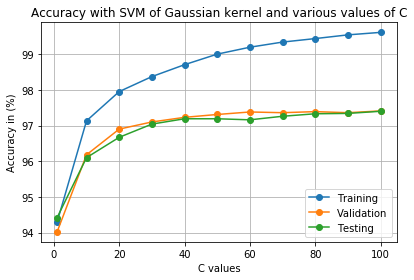

In [12]:
import pickle
import matplotlib.pyplot as plt
pickle.dump((training_accuracy, validation_accuracy, testing_accuracy),open("C_Results.pickle","wb"))

# Plot accuracy of SVM with rbf vs C values
plt.plot(C, training_accuracy, 'o-',
    C, validation_accuracy,'o-',
    C, testing_accuracy, 'o-')

plt.title('Accuracy with SVM of Gaussian kernel and various values of C')
plt.xlabel('C values')
plt.ylabel('Accuracy in (%)')
plt.legend(('Training','Validation','Testing'), loc='lower right')
plt.tight_layout()
plt.grid(True)
plt.savefig("plot_image.png")
plt.show()

In [38]:
    args=args_b
    params=initialWeights_b
    print(np.shape(params))
    train_data, labeli = args
    print(np.shape(train_data))
    print(np.shape(labeli))
    n_data = train_data.shape[0]
    n_feature = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_feature + 1, n_class))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    w = params.reshape((n_feature+1,10))
    x = np.hstack((np.ones((n_data,1)),train_data))
        
    n=np.exp(np.dot(x,params.reshape(716,10)))
        
    d_sum=np.sum(n,axis=1)
    
    d=d_sum.reshape(d_sum.shape[0],1)
    
    y=n/d
    
    error = -np.sum(np.sum(labeli*np.log(y) + (1.0 - labeli) * np.log(1.0 - y)))

    error_grad = np.dot(np.transpose(x) , (y-labeli))
    
    error_grad=error_grad.ravel()

(716, 10)
(50000, 715)
(50000, 10)


In [26]:
error

162541.48669572402

In [39]:
np.shape(error_grad)

(7160,)

In [13]:
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# number of classes
n_class = 10

# number of training samples
n_train = train_data.shape[0]

# number of features
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()

# Logistic Regression with Gradient Descent
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1))
opts = {'maxiter': 100}

# FOR EXTRA CREDIT ONLY
W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class))
opts_b = {'maxiter': 100}

args_b = (train_data, Y)

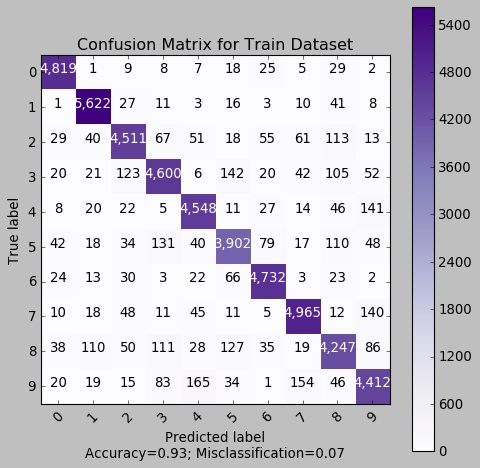

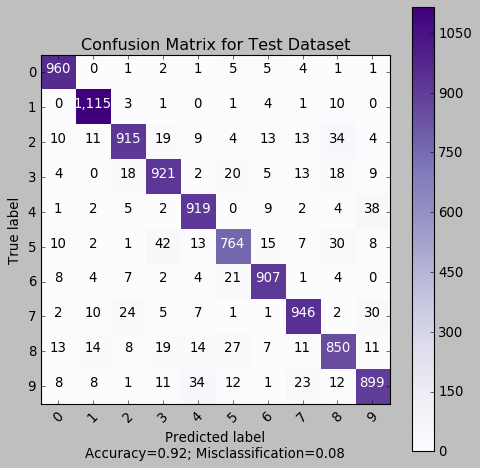

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    acc = np.trace(cm) / float(np.sum(cm))
    mc = 1 - acc

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\nAccuracy={:0.2f}; Misclassification={:0.2f}'.format(acc, mc))
    plt.style.use('classic')
    plt.show()
    

cf_train=metrics.confusion_matrix(train_label,predicted_label_tr)
cf_test=metrics.confusion_matrix(test_label,predicted_label_te)

plot_confusion_matrix(cm=cf_train,normalize=False,target_names=['0','1','2','3','4','5','6','7','8','9'],title="Confusion Matrix for Train Dataset")

plot_confusion_matrix(cm=cf_test,normalize=False,target_names=['0','1','2','3','4','5','6','7','8','9'],title="Confusion Matrix for Test Dataset")

In [64]:
print("Report for Training data")
print(metrics.classification_report(predicted_label_tr,train_label))
print("Report for Testing data")
print(metrics.classification_report(predicted_label_te,test_label))

Report for Training data
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      5011
           1       0.98      0.96      0.97      5882
           2       0.91      0.93      0.92      4869
           3       0.90      0.91      0.91      5030
           4       0.94      0.93      0.93      4915
           5       0.88      0.90      0.89      4345
           6       0.96      0.95      0.96      4982
           7       0.94      0.94      0.94      5290
           8       0.88      0.89      0.88      4772
           9       0.89      0.90      0.90      4904

   micro avg       0.93      0.93      0.93     50000
   macro avg       0.93      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000

Report for Testing data
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1016
           1       0.98      0.96      0.97      1166
           2       0.89      

In [55]:
# -*- coding: utf-8 -*-
"""
Created on Tue May  7 01:31:17 2019

@author: siddi
"""

import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn import svm
import matplotlib.pyplot as plt
import pickle


def preprocess():
    """ 
     Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set
    """

    mat = loadmat('C:/Users/siddi/Desktop/Machine Learning/Project-3/Assignment3/basecode/mnist_all.mat')  # loads the MAT object as a Dictionary

    n_feature = mat.get("train1").shape[1]
    n_sample = 0
    for i in range(10):
        n_sample = n_sample + mat.get("train" + str(i)).shape[0]
    n_validation = 1000
    n_train = n_sample - 10 * n_validation

    # Construct validation data
    validation_data = np.zeros((10 * n_validation, n_feature))
    for i in range(10):
        validation_data[i * n_validation:(i + 1) * n_validation, :] = mat.get("train" + str(i))[0:n_validation, :]

    # Construct validation label
    validation_label = np.ones((10 * n_validation, 1))
    for i in range(10):
        validation_label[i * n_validation:(i + 1) * n_validation, :] = i * np.ones((n_validation, 1))

    # Construct training data and label
    train_data = np.zeros((n_train, n_feature))
    train_label = np.zeros((n_train, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("train" + str(i)).shape[0]
        train_data[temp:temp + size_i - n_validation, :] = mat.get("train" + str(i))[n_validation:size_i, :]
        train_label[temp:temp + size_i - n_validation, :] = i * np.ones((size_i - n_validation, 1))
        temp = temp + size_i - n_validation

    # Construct test data and label
    n_test = 0
    for i in range(10):
        n_test = n_test + mat.get("test" + str(i)).shape[0]
    test_data = np.zeros((n_test, n_feature))
    test_label = np.zeros((n_test, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("test" + str(i)).shape[0]
        test_data[temp:temp + size_i, :] = mat.get("test" + str(i))
        test_label[temp:temp + size_i, :] = i * np.ones((size_i, 1))
        temp = temp + size_i

    # Delete features which don't provide any useful information for classifiers
    sigma = np.std(train_data, axis=0)
    index = np.array([])
    for i in range(n_feature):
        if (sigma[i] > 0.001):
            index = np.append(index, [i])
    train_data = train_data[:, index.astype(int)]
    validation_data = validation_data[:, index.astype(int)]
    test_data = test_data[:, index.astype(int)]

    # Scale data to 0 and 1
    train_data /= 255.0
    validation_data /= 255.0
    test_data /= 255.0

    return train_data, train_label, validation_data, validation_label, test_data, test_label


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


def blrObjFunction(initialWeights, *args):
    """
    blrObjFunction computes 2-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector (w_k) of size (D + 1) x 1 
        train_data: the data matrix of size N x D
        labeli: the label vector (y_k) of size N x 1 where each entry can be either 0 or 1 representing the label of corresponding feature vector

    Output: 
        error: the scalar value of error function of 2-class logistic regression
        error_grad: the vector of size (D+1) x 1 representing the gradient of
                    error function
    """
    train_data, labeli = args

    n_data = train_data.shape[0]
    n_features = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_features + 1, 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    w = initialWeights.reshape((n_feature+1,1))
    
    x = np.hstack((np.ones((n_data,1)),train_data))
    xw = np.dot(x,w)
    y = sigmoid(xw)

    log_error = -(labeli * np.log(y) + (1.0 - labeli) * np.log(1.0 - y))
    error = np.sum(log_error)

    error_grad_mat = (y - labeli) * x
    error_grad = np.sum(error_grad_mat, axis=0)
    
    return error, error_grad


def blrPredict(W, data):
    """
     blrObjFunction predicts the label of data given the data and parameter W 
     of Logistic Regression
     
     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight 
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D
         
     Output: 
         label: vector of size N x 1 representing the predicted label of 
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    x = np.hstack((np.ones((data.shape[0], 1)),data))
    xw = np.dot(x, W)
    sig_fun = sigmoid(xw)   
    label_max = np.argmax(sig_fun, axis=1)   
    label = label_max.reshape((data.shape[0],1))
    return label

def mlrObjFunction(params, *args):
    """
    mlrObjFunction computes multi-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights_b: the weight vector of size (D + 1) x 10
        train_data: the data matrix of size N x D
        labeli: the label vector of size N x 1 where each entry can be either 0 or 1
                representing the label of corresponding feature vector

    Output:
        error: the scalar value of error function of multi-class logistic regression
        error_grad: the vector of size (D+1) x 10 representing the gradient of
                    error function
    """
    train_data, labeli = args
    n_data = train_data.shape[0]
    n_feature = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_feature + 1, n_class))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    w = params.reshape((n_feature+1,10))
    x = np.hstack((np.ones((n_data,1)),train_data))
        
    n=np.exp(np.dot(x,w))
        
    d_sum=np.sum(n,axis=1)
    
    d=d_sum.reshape(d_sum.shape[0],1)
    
    y=n/d
    
    error = -np.sum(np.sum(labeli*np.log(y) + (1.0 - labeli) * np.log(1.0 - y)))

    error_grad = np.dot(np.transpose(x) , (y-labeli))
    
    error_grad=error_grad.ravel()
    
    return error, error_grad


def mlrPredict(W, data):
    """
     mlrObjFunction predicts the label of data given the data and parameter W
     of Logistic Regression

     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D

     Output:
         label: vector of size N x 1 representing the predicted label of
         corresponding feature vector given in data matrix

    """
    label = np.zeros((data.shape[0], 1))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    x = np.hstack((np.ones((data.shape[0], 1)),data))
    n=np.exp(np.dot(x,W))
        
    w_sum=np.sum(n,axis=1)
    d=w_sum.reshape(w_sum.shape[0],1)
    
    t=n/d   
    label_max = np.argmax(t, axis=1)   
    label = label_max.reshape((data.shape[0],1))
    return label




"""
Script for Extra Credit Part
"""
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# number of classes
n_class = 10

# number of training samples
n_train = train_data.shape[0]

# number of features
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()

# Logistic Regression with Gradient Descent
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1))
opts = {'maxiter': 100}

# FOR EXTRA CREDIT ONLY
W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class))
opts_b = {'maxiter': 100}

args_b = (train_data, Y)
nn_params = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)
W_b = nn_params.x.reshape((n_feature + 1, n_class))

# Find the accuracy on Training Dataset
predicted_label_b_tr = mlrPredict(W_b, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label_b_tr == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label_b = mlrPredict(W_b, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label_b == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_b_te = mlrPredict(W_b, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label_b_te == test_label).astype(float))) + '%')



 Training set Accuracy:92.99%

 Validation set Accuracy:92.45%

 Testing set Accuracy:92.38%


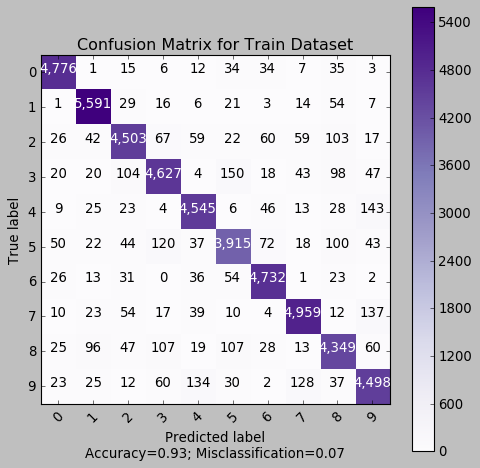

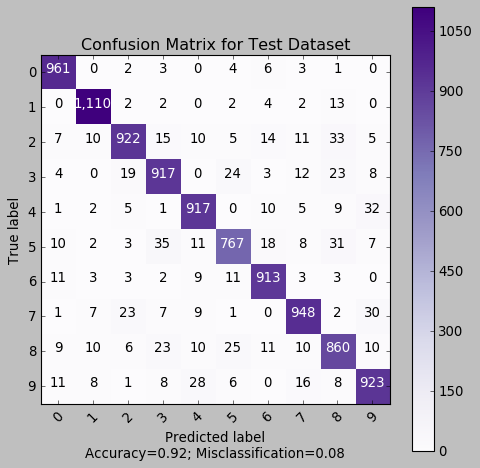

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn import metrics
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    acc = np.trace(cm) / float(np.sum(cm))
    mc = 1 - acc

    if cmap is None:
        cmap = plt.get_cmap('Purples')

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\nAccuracy={:0.2f}; Misclassification={:0.2f}'.format(acc, mc))
    
    plt.style.use('classic')
    plt.show()
    

cf_train=metrics.confusion_matrix(train_label,predicted_label_b_tr)
cf_test=metrics.confusion_matrix(test_label,predicted_label_b_te)
plot_confusion_matrix(cm=cf_train,normalize=False,target_names=['0','1','2','3','4','5','6','7','8','9'],title="Confusion Matrix for Train Dataset")
plot_confusion_matrix(cm=cf_test,normalize=False,target_names=['0','1','2','3','4','5','6','7','8','9'],title="Confusion Matrix for Test Dataset")

In [66]:
print("Report for Training data")
print(metrics.classification_report(predicted_label_b_tr,train_label))
print("Report for Testing data")
print(metrics.classification_report(predicted_label_b_te,test_label))

Report for Training data
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4966
           1       0.97      0.95      0.96      5858
           2       0.91      0.93      0.92      4862
           3       0.90      0.92      0.91      5024
           4       0.94      0.93      0.93      4891
           5       0.89      0.90      0.89      4349
           6       0.96      0.95      0.95      4999
           7       0.94      0.94      0.94      5255
           8       0.90      0.90      0.90      4839
           9       0.91      0.91      0.91      4957

   micro avg       0.93      0.93      0.93     50000
   macro avg       0.93      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000

Report for Testing data
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1015
           1       0.98      0.96      0.97      1152
           2       0.89      